## Table of Contents

- [Prework](#Prework)
    - [Visualisaton for IV and HV](#Visualisaton_for_IV_and_HV)
        - [Summary statistics](#Summary_statistics)
        - [Data visualization](#Data_visualization)
        - [Stationarity check](#Stationarity_check)
        - [Performance metrics](#Performance_metrics)

- [Build Model](#Build_Model)
    - [Split trainning and testing dataset using VIX](#Split_trainning_and_testing_dataset_using_VIX)
    - [Benchmark - Multi-Layer Perceptron (MLP)](#Benchmark_Multi-Layer_Perceptron_(MLP))
    - [Build the ARIMA model using IV](#Build_the_ARIMA_model_using_IV)
    - [Build ANN model - LSTM](#Build_ANN_model_LSTM)
    - [Build ANN model - GRU](#Build_ANN_model_GRU)
    - [Build LSTM-ARIMA model](#Build_LSTM-ARIMA_model)
    - [Build ARIMA-LSTM model](#Build_ARIMA-LSTM_model)
    - [Build GRU-ARIMA model](#Build_GRU-ARIMA_model)
    - [Build ARIMA-GRU model](#Build_ARIMA-GRU_model)

- [Overall](#Overall)
    - [Combine models prediction results](#Combine_models_prediction_results)
    - [Evaluation method: index metrics](#Evaluation_method_index_metrics)


## Prework

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.stattools import adfuller as adf
import tensorflow as tf
import random as rn
import os
from scipy.stats import norm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import arch
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [48]:
# #Import data from downloaded excel files
USA_file_path = r"F:\下载\dissertation\USA.xlsx"

USA = pd.read_excel(USA_file_path, index_col="Date")


### Visualisaton_for_IV_and_HV

#### Summary_statistics

In [49]:
print(USA['Price'].describe())

count    8702.000000
mean       19.512204
std         7.879792
min         9.140000
25%        13.830000
50%        17.665000
75%        22.890000
max        82.690000
Name: Price, dtype: float64


#### Data_visualization

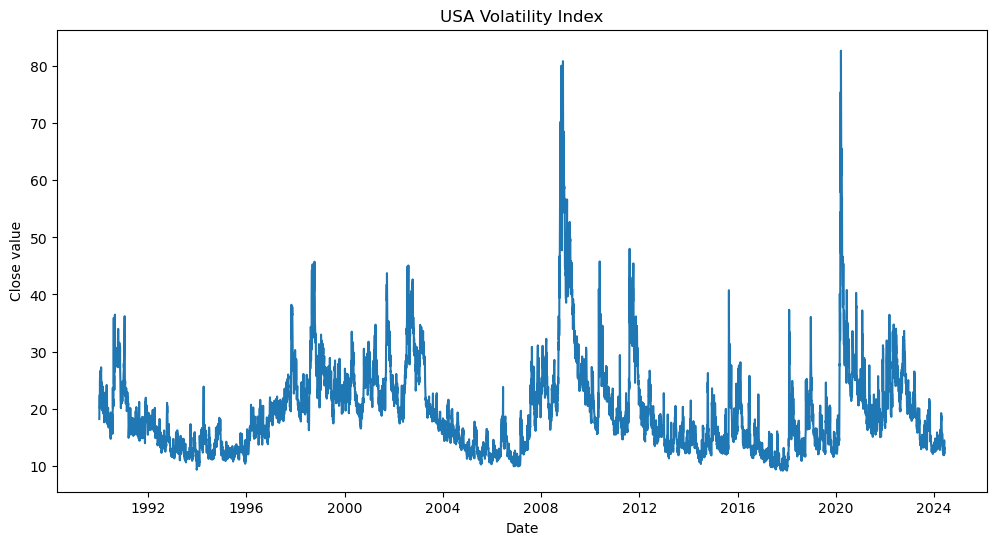

In [50]:
plt.figure(figsize=(12, 6))
# Create a line plot of the VIX close price
plt.plot(USA.index, USA['Price'])

# Set the title and axis labels
plt.title('USA Volatility Index')
plt.xlabel('Date')
plt.ylabel('Close value')

# Display the plot
plt.show()

#### Stationarity_check

In [51]:
USA_close = USA['Price'].dropna()

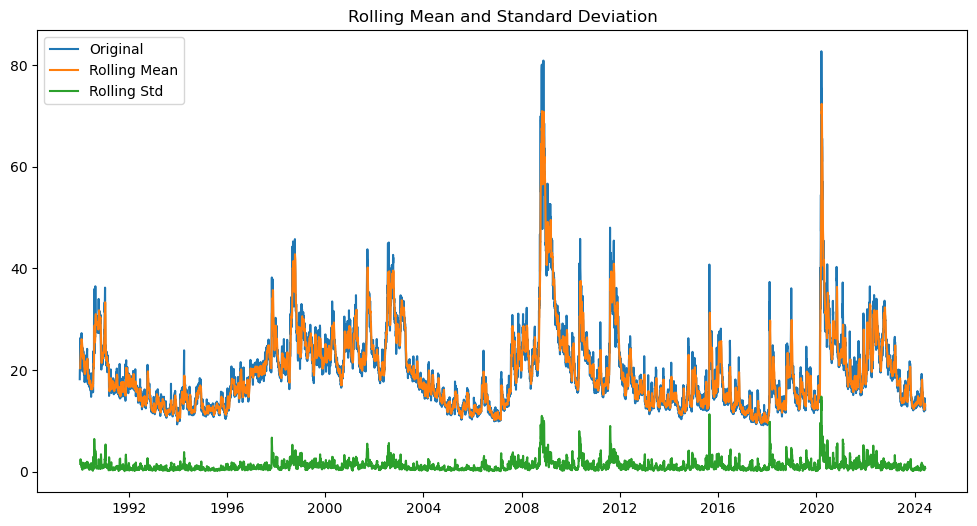

ADF Test Results:
ADF Statistic: -6.915992408519366
p-value: 1.1791228321848077e-09
Critical Values:
   1%: -3.4311026443993713
   5%: -2.8618726185365015
   10%: -2.5669470478895313
KPSS Test Results:
KPSS Statistic: 0.3615512812026848
p-value: 0.09372789603332551
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


In [52]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot rolling mean and standard deviation
def plot_rolling_statistics(timeseries, window=7):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print("KPSS Test Results:")
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

# Check stationarity by plotting rolling statistics and conducting tests
plot_rolling_statistics(USA['Price'])

adf_test(USA_close)

kpss_test(USA_close)


#### Performance_metrics

In [53]:
# Calculate performance metrics
def evaluation(test_data, model_predictions):
    mse = mean_squared_error(test_data, model_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, model_predictions)
    r2 = r2_score(test_data, model_predictions)

    print("Performance Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2) Score:", r2)

## Build_Model

### Split_trainning_and_testing_dataset_using_VIX

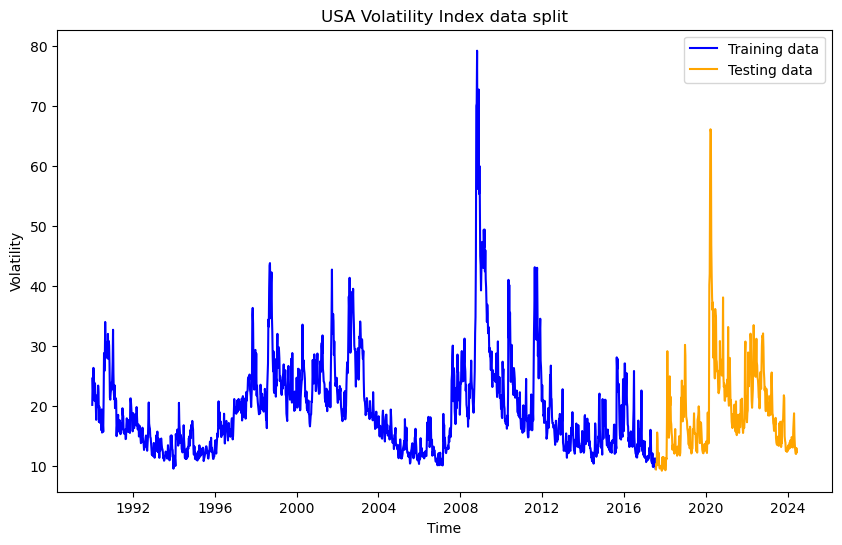

In [54]:
# Convert to the weekly dataset 
volatility_data = USA['Price'].dropna().resample("W").last()

# Split the data into training, validation and test sets
train_size = int(len(volatility_data)*0.8)
test_size = len(volatility_data) - train_size

train_data = volatility_data[:train_size]
test_data = volatility_data[train_size:]
train_dates = train_data.index
test_dates = test_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train_data, label="Training data", color="blue")
plt.plot(test_data, label="Testing data", color="orange")
plt.title("USA Volatility Index data split")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Benchmark_Multi-Layer_Perceptron_(MLP)

In [55]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
model_mlp.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for MLP (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Make predictions on the test data
predicted_values_mlp = model_mlp.predict(X_test)
predicted_values_mlp = scaler.inverse_transform(predicted_values_mlp)


Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 0.0084 
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0027
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0036
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0028
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0027
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0022
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0031
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0019
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0017
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0018
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


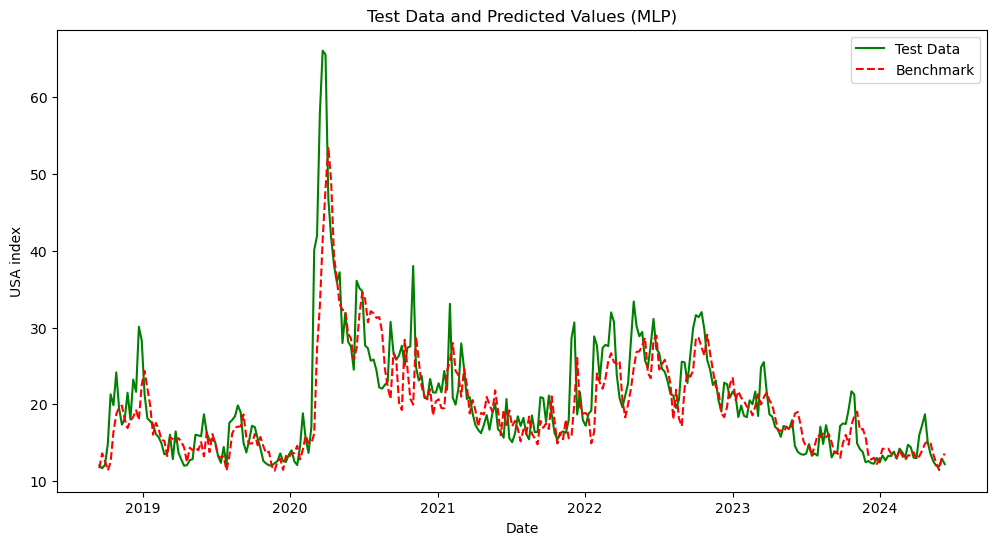

In [56]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='red', linestyle='dashed', label='Benchmark')
plt.title('Test Data and Predicted Values (MLP)')
plt.xlabel('Date')
plt.ylabel('USA index')
plt.legend()
plt.show()

### Build_the_ARIMA_model_using_IV

Build a GARCH(1,1) model, and use the model to calculate fitted and predicted volatility of SP500 index. Plot the graph for original historical volatility and the predicted value, for the predicted value, use different color to show the fitted and predicted datasets.

In [57]:
# Train AutoARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6993.362, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7067.295, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7019.851, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7018.440, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7065.304, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7019.935, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6992.038, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7020.334, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7021.172, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6993.516, Time=0.85 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7019.358, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6993.354, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6990.157, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7018.351, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]          

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [58]:
history = [x for x in train_data]
predicted_values_arima = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5904\3447781384.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


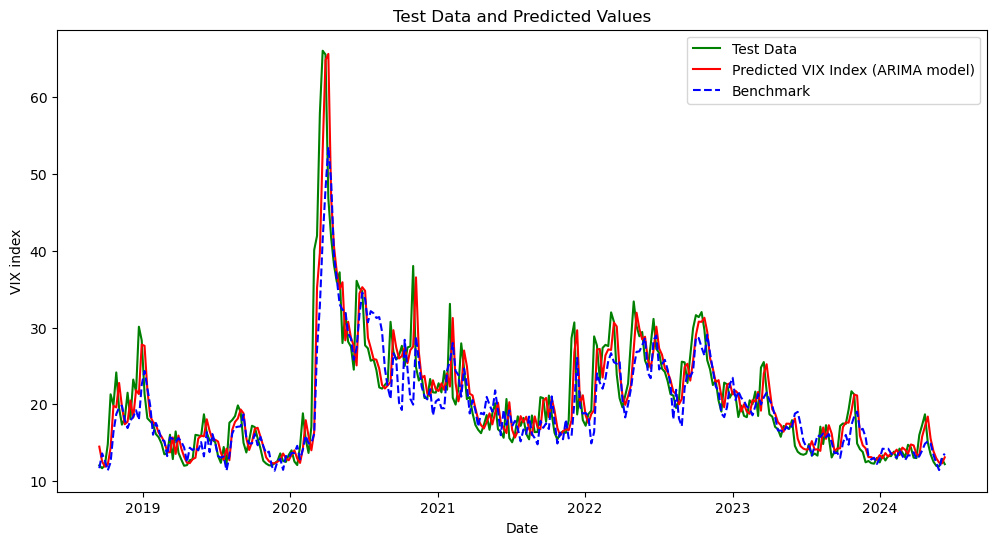

In [59]:
# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the test data with a solid green line
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data', linestyle='-')

# Plot the predicted values from the ARIMA model with a dashed red line
plt.plot(test_dates[60:], predicted_values_arima[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA model)')

# Plot the predicted values from the MLP model with a dash-dot blue line
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('VIX index')

# Move the legend outside the plot area to avoid overlapping the lines
plt.legend()

plt.show()


In [60]:
evaluation(test_data, predicted_values_arima)

Performance Metrics:
Mean Squared Error (MSE): 12.617809564548493
Root Mean Squared Error (RMSE): 3.5521556222311674
Mean Absolute Error (MAE): 2.2148463356246757
R-squared (R^2) Score: 0.7898162337182207


### Build_ANN_model_LSTM

In [15]:
#Hyperparemeter tuning: grid search for hyperparameter tuning.

Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0163
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0065
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0038
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0042
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0170
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0060
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0044
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0102
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0028
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0108
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0053
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0029
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0170
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0021
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0028
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0076
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0020
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0017
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0016
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0166
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0092
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0114
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0656
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0072
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0025
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0034
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0034
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0362
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0054
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0018
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0211
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0019
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0016
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0015
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0015
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0011
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0010
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.4028
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1083
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0225
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0177
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0210
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0185
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0160
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0166
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0180
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0169
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.7747
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1853
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0642
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2590
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0158
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0128
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0089
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0049
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0040
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.6111
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1388
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0127
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0107
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0094
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0080
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0092
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0093
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0101
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0104
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.9811
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0162
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0142
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0156
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0148
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0150
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0162
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0177
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0187
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0176
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 13.1110
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0191
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0157
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0132
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0146
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0109
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0145
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0131
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0164
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0145
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 6.5145
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0105
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0125
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0156
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0119
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0107
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0105
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0096
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0089
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0112
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0146
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0056
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0058
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0038
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0035
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0148
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0063
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0040
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0033
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0025
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0114
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0030
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0014
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0014
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0114
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0041
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0047
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0042
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0040
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0023
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0034
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0117
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0059
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0052
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0028
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0030
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0034
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0021
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0028
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0022
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0076
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0017
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0015
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0016
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0119
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0045
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0159
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0047
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0103
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010    
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.9379e-04
Epoch 1

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0227
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0031
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0028
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0020
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0023
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0023
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0550
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0047
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0035
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0024
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0022
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0226
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0014
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0014
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.7211
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0183
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0174
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0152
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0187
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0153
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0181
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0176
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0180
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0192
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0186
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0170
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0183
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0194
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0226
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.1200
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0238
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0127
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0195
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0200
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0161
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0171
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0151
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0171
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0216
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0184
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0166
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0178
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0299
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0196
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.7874
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0090
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0084
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0113
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0120
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0095
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0084
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0098
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0095
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0086
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0064
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 8.9027
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0199
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0175
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0154
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0187
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0195
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0225
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0181
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0171
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0158
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0194
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0235
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0200
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0226
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0183
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 12.6990
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2869
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0328
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0173
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0146
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0133
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0161
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0147
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0177
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0195
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0197
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0170
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0147
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0208
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0195
Epoch 16/20
29

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 4.8652
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0186
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0088
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0089
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0094
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0104
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0101
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0107
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0140
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0092
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0125
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0099
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0082
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0097
Epoch 16/20
29/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0165
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0063
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0052
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0183
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0052
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0054
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0042
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0036
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0127
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0025
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0024
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0022
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0024
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0018
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0181
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0052
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0045
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0040
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0042
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0037
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0037
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0032
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0028
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0027
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0119
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0053
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0051
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0059
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0041
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0030
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0030
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0028
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0027
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0040
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0088
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0029
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0030
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0027
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0021
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0022
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0021
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0018
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0018
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0017
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0179
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0055
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0027
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0024
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0023
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0260
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0054
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0054
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0024
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0288
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0027
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0017
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0016
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0431
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0067
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0031
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0035
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0030
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0024
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0033
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0027
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0021
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0027
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0575
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0053
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0045
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0035
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0025
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0028
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0021
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0025
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0023
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0019
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - loss: 0.0247
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0032
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0022
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0021
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0017
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0016
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0014
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0012
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0011
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0010
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.7914
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0192
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0155
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0117
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0062
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0044
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0034
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0030
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0021
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0025
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.7040
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0555
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0237
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0192
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0183
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0149
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0149
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0183
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0155
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0191
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.2443
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.3878
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0293
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0105
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0090
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0089
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0086
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0086
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0087
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0083
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 11.1716
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.2188
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0260
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0203
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0167
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0185
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0137
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0148
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0207
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0193
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 22.0247
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.2751
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.2354
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3864
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0865
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0417
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0194
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0139
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0136
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0134
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 17.6118
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0114
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0091
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0089
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0094
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0086
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0083
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0082
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0106
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0089
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0179
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0062
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0054
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0057
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0051
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0066
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0046
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0038
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0043
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0038
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0044
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0029
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0031
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0032
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0150
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0060
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0058
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0052
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0038
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0038
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0034
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0034
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0045
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0027
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0027
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0122
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0025
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0020
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0018
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0018
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0182
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0071
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0040
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0043
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0048
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0043
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0034
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0040
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0032
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0037
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0033
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0030
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0028
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0028
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0027
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0190
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0059
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0041
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0039
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0048
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0041
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0041
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0035
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0036
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0024
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0020
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0022
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0027
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0025
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0020
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0090
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0029
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0026
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0022
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0020
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0021
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0020
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0019
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0016
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0017
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0015
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0015
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0015
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0014
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0013
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0338
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0052
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0043
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0025
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0180
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0055
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0039
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0025
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0023
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0018
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0459
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0021
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0020
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0018
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0014
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1116
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0080
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0046
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0049
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0036
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0031
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0031
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0039
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0030
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0030
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0030
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0029
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0022
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0025
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0024
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0577
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0054
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0044
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0033
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0032
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0037
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0025
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0032
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0026
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0029
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0021
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0023
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0020
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0021
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0019
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0670
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0049
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0024
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0025
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0021
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0018
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0018
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0017
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0017
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0015
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0016
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0013
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0013
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0011
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0012
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.5596
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0586
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0154
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0104
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0100
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0238
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0155
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0123
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0066
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0316
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0137
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0078
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0044
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.5882
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0310
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0182
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0176
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0159
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0151
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0167
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0154
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0180
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0136
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0157
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0146
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0167
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0160
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0194
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.7226
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1014
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0137
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0080
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0091
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0082
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0082
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0092
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0084
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0096
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0084
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0086
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0107
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 2.5112
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2543
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0440
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0259
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0177
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0161
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0176
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0161
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0146
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0169
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0161
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0203
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0199
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0145
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0181
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 17.7159
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0842
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0169
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0168
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0127
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0126
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0062
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0072
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0061
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0076
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0039
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0059
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0055
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0056
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0053
Epoch 16/20
15

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7.6128
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0261
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0114
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0083
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0090
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0085
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0083
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0081
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0085
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0091
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0099
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0091
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0090
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0099
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0106
Epoch 16/20
15/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0135
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0036
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0032
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0027
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0025
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0025
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0022
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0020
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0032
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0018
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0016
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0020
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0015
Epoch 16/20
44/

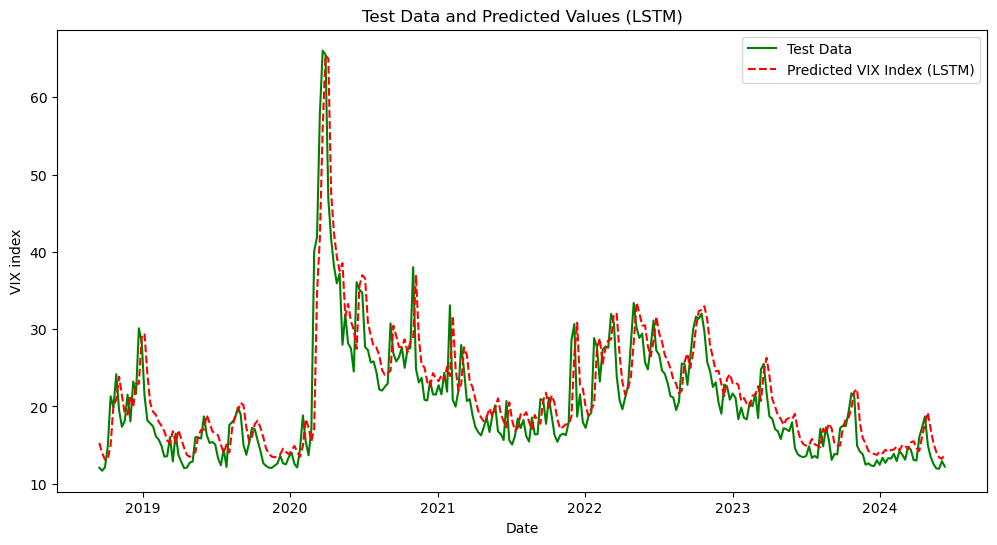

In [65]:
# Normalize the data
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_normalized, lookback)
X_test, y_test = create_sequences(test_data_normalized, lookback)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model as a scikit-learn estimator
regressor = KerasRegressor(model=create_lstm_model, units=50, learning_rate=0.001)

# Perform hyperparameter tuning using grid search
param_grid = {
    'model__units': [50, 100], 
    'batch_size': [32, 64], 
    'epochs': [10, 20], 
    'model__learning_rate': [0.001, 0.01, 0.1]
}
model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_units = model.best_params_['model__units']
best_batch_size = model.best_params_['batch_size']
best_epochs = model.best_params_['epochs']
best_learning_rate = model.best_params_['model__learning_rate']

print(f"Best Hyperparameters: units={best_units}, batch_size={best_batch_size}, epochs={best_epochs}, learning_rate={best_learning_rate}")

# Train the LSTM model with the best hyperparameters
final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Make predictions on the test data
predicted_values_lstm = final_model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='dashed', label='Predicted VIX Index (LSTM)')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()



In [26]:
#Best Hyperparameters: units=50, batch_size=64, epochs=20, learning_rate=0.01

In [66]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0110
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0042
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0022
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0019
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 16/20
44/

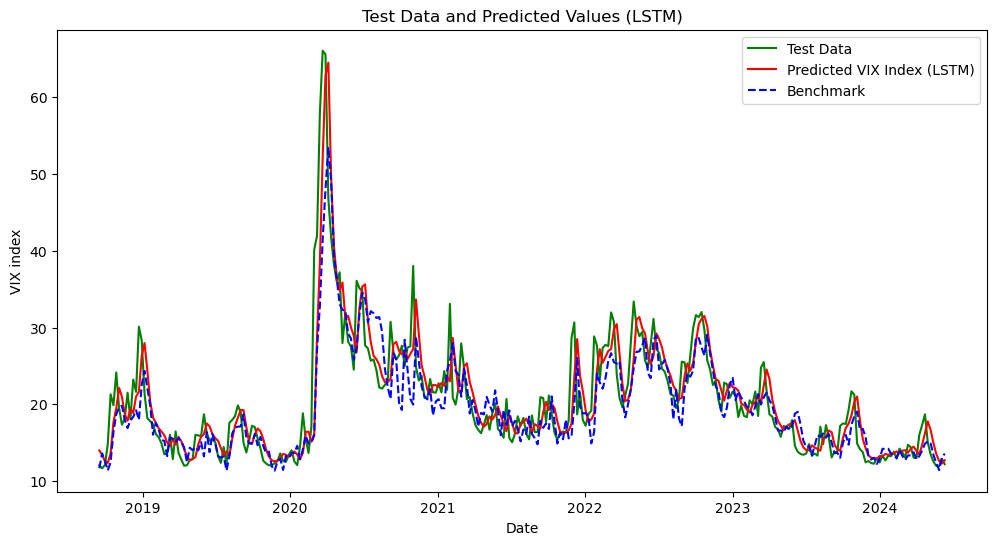

In [67]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='-', label='Predicted VIX Index (LSTM)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [68]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 14.745630223381873
Root Mean Squared Error (RMSE): 3.840003935334165
Mean Absolute Error (MAE): 2.5157912902832025
R-squared (R^2) Score: 0.7560593647908519


In [69]:
evaluation(test_data[lookback:], predicted_values_mlp)

Performance Metrics:
Mean Squared Error (MSE): 19.76720681201334
Root Mean Squared Error (RMSE): 4.446032704784496
Mean Absolute Error (MAE): 2.7870753609975183
R-squared (R^2) Score: 0.6729861719720234


### Build_ANN_model_GRU

In [70]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0094
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0016
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0016
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015
Epoch 16/20
44/

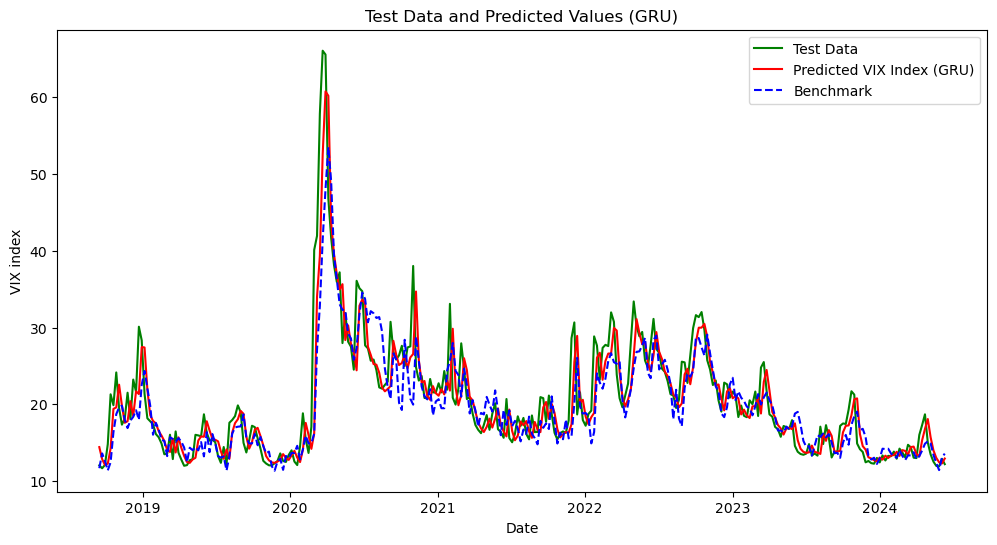

In [71]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru, color='red', linestyle='-', label='Predicted VIX Index (GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [72]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 12.881128812142807
Root Mean Squared Error (RMSE): 3.5890289511430256
Mean Absolute Error (MAE): 2.2456428676605227
R-squared (R^2) Score: 0.7869042762470472


### Build_LSTM-ARIMA_model

In [73]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm_arima = scaler.inverse_transform(model_lstm.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0380
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0151
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0172
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0064
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0093
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0136
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0130
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0111
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0100
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0106
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0132
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0081
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0086
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0080
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0063
Epoch 16/20
10/

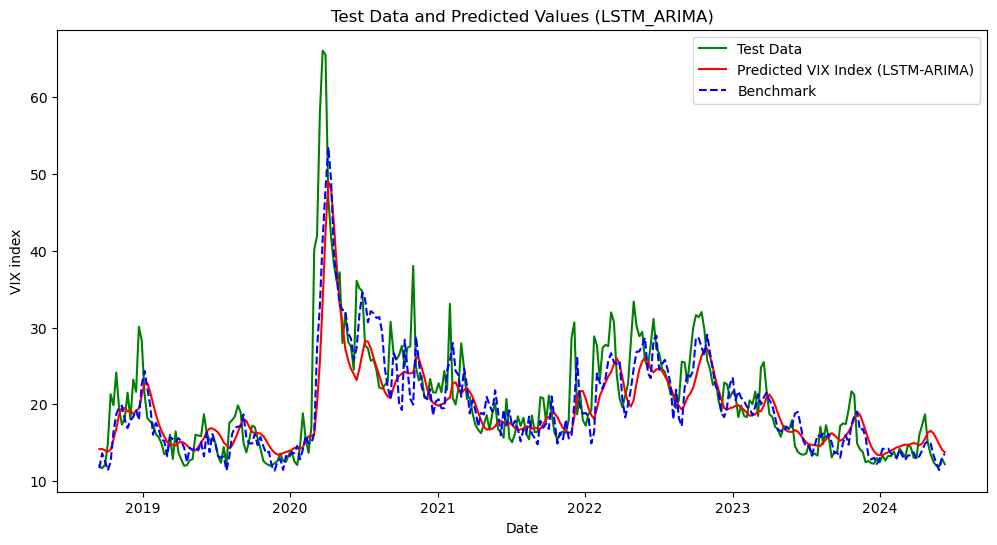

In [74]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm_arima, color='red', linestyle='-', label='Predicted VIX Index (LSTM-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (LSTM_ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [75]:
evaluation(test_data[lookback:], predicted_values_lstm_arima)

Performance Metrics:
Mean Squared Error (MSE): 24.897887321611776
Root Mean Squared Error (RMSE): 4.9897782838129965
Mean Absolute Error (MAE): 3.0064383721669516
R-squared (R^2) Score: 0.5881080458013273


### Build_ARIMA-LSTM_model

In [76]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_lstm]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1290.198, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2042.140, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1385.213, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1713.196, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2701.869, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1288.211, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1492.933, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1307.348, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1290.204, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1403.558, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1292.061, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1291.163, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1306.072, Time=0.05 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.360 seconds


ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

In [77]:
#One_step ahead forecast
predicted_values_arima_lstm = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_lstm.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_5904\1596724072.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


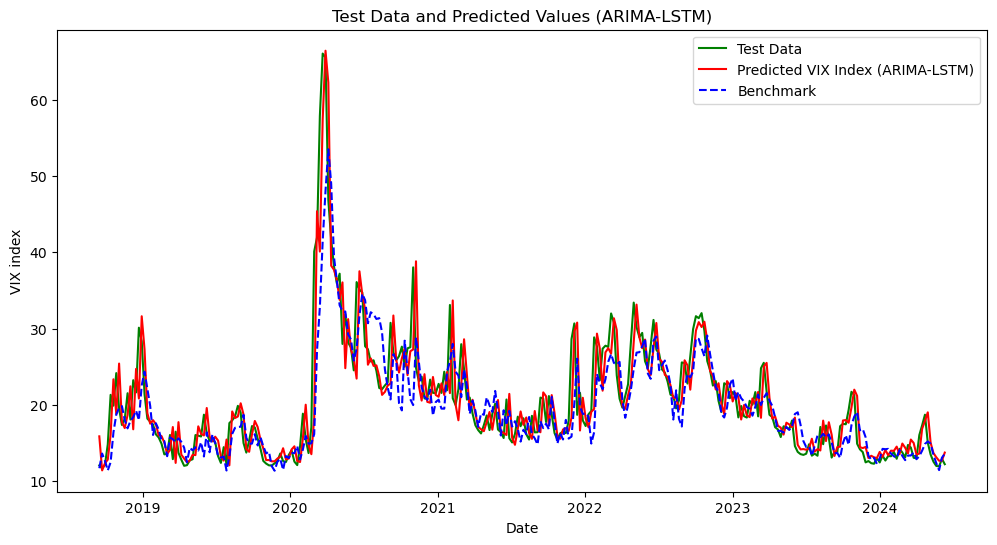

In [78]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_lstm[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-LSTM)')
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (ARIMA-LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [79]:
evaluation(test_data, predicted_values_arima_lstm)

Performance Metrics:
Mean Squared Error (MSE): 13.433988566436987
Root Mean Squared Error (RMSE): 3.6652405877973395
Mean Absolute Error (MAE): 2.346196738161192
R-squared (R^2) Score: 0.7762205635902601


### Build_GRU-ARIMA_model

In [80]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru_arima = scaler.inverse_transform(model_gru.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0266
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0114
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0079
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0073
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0059
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0072
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0060
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0072
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0054
Epoch 16/20
10/

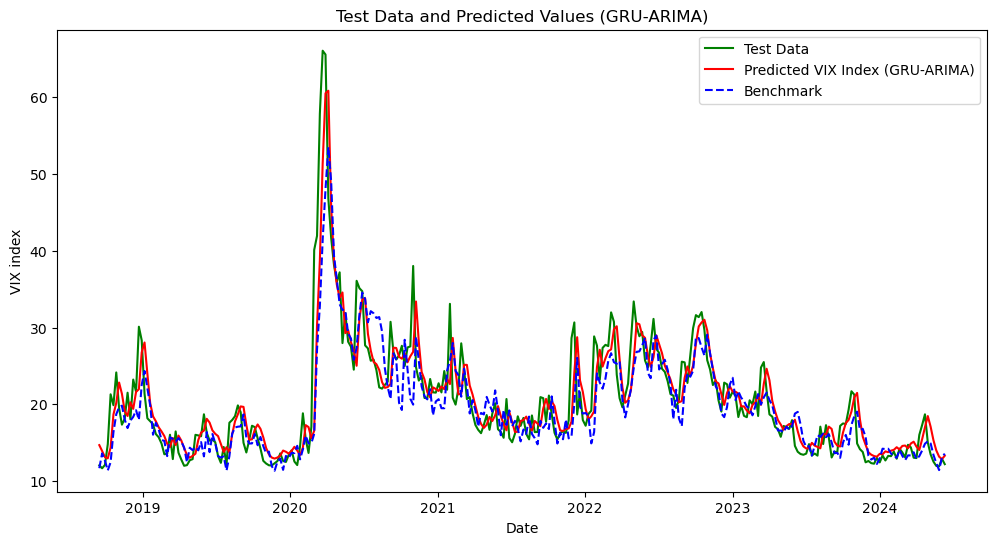

In [81]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru_arima, color='red', linestyle='-', label='Predicted VIX Index (GRU-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GRU-ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
#plt.grid(True)
plt.show()

### Build_ARIMA-GRU_model

In [84]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_gru]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1455.762, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2018.118, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1465.957, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1750.558, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2684.694, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1456.533, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1456.936, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1454.440, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1457.066, Time=0.20 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1453.032, Time=0.43 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1458.538, Time=0.20 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1457.371, Time=0.44 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1457.132, Time=0.47 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1459.376, Time=0.41 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept

ARIMA(order=(4, 0, 2), scoring_args={}, suppress_warnings=True)

In [85]:
#When using the ARIMA-GRU model for time series forecasting, if the automatically selected optimal model (4,0,2) leads to numerical instability issues, 
#the model order can be reduced to (3,0,2) to improve stability and avoid errors.
#One_step ahead forecast
predicted_values_arima_gru = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_gru.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_5904\1040962809.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

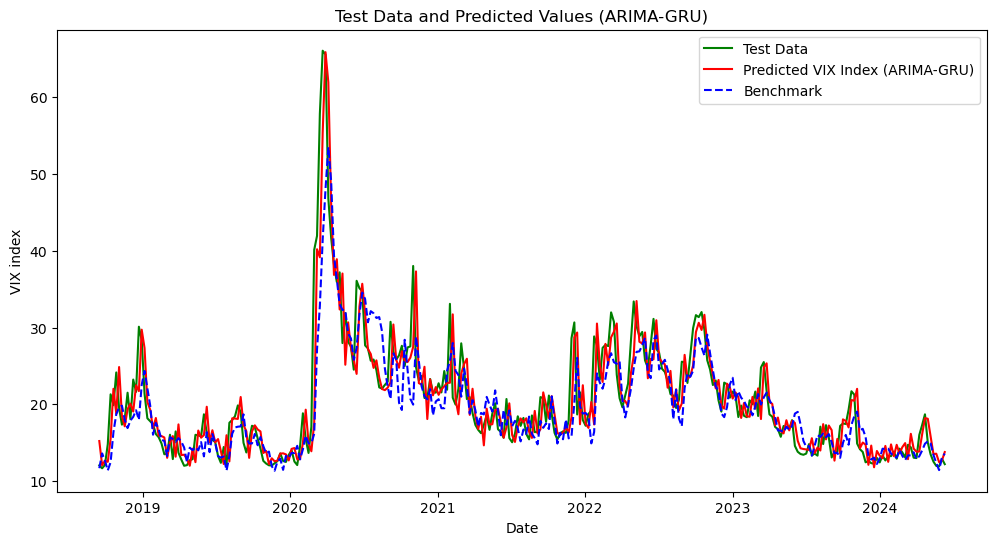

In [86]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_gru[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (ARIMA-GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [87]:
evaluation(test_data, predicted_values_arima_gru)

Performance Metrics:
Mean Squared Error (MSE): 12.359790287239528
Root Mean Squared Error (RMSE): 3.515649340767581
Mean Absolute Error (MAE): 2.2533355624380196
R-squared (R^2) Score: 0.794114243067678


## Overall

### Combine_models_prediction_results

In [88]:
y_lstm = pd.Series([x[0] for x in predicted_values_lstm], index = test_dates[60:])
y_lstm_arima = pd.Series([x[0] for x in predicted_values_lstm_arima], index = test_dates[60:])
y_arima_lstm = pd.Series(predicted_values_arima_lstm[60:],index =test_dates[60:])
y_gru = pd.Series([x[0] for x in predicted_values_gru], index = test_dates[60:])
y_gru_arima = pd.Series([x[0] for x in predicted_values_gru_arima], index = test_dates[60:])
y_arima_gru = pd.Series(predicted_values_arima_gru[60:],index =test_dates[60:])
y_benchmark = pd.Series([x[0] for x in predicted_values_mlp], index = test_dates[60:])
y_test = test_data[60:]

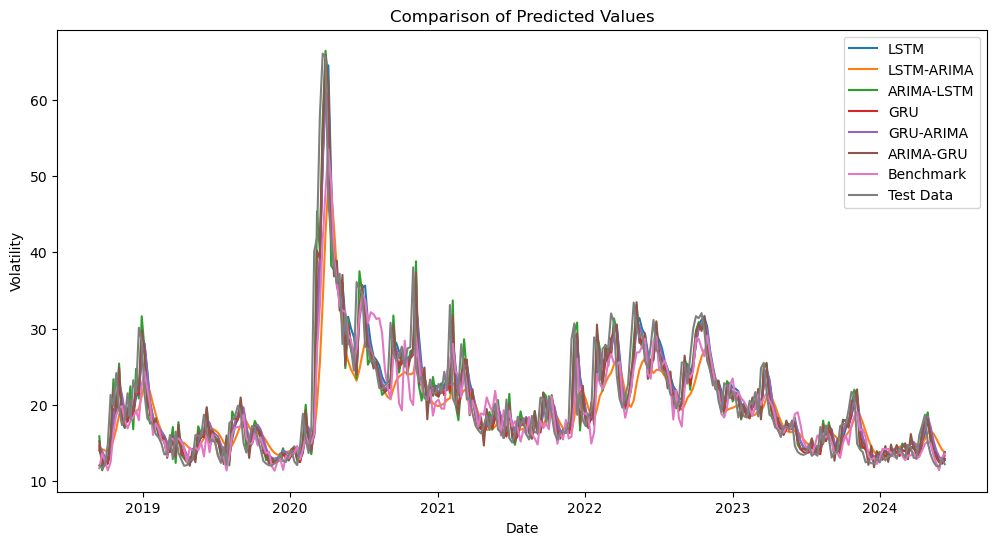

In [89]:
plt.figure(figsize=(12, 6))
# Plot the y-values
plt.plot(y_lstm, label='LSTM')
plt.plot(y_lstm_arima, label='LSTM-ARIMA')
plt.plot(y_arima_lstm, label='ARIMA-LSTM')
plt.plot(y_gru, label='GRU')
plt.plot(y_gru_arima, label='GRU-ARIMA')
plt.plot(y_arima_gru, label='ARIMA-GRU')
plt.plot(y_benchmark, label='Benchmark')
plt.plot(y_test, label='Test Data')

# Set the title and labels
plt.title('Comparison of Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Display the plot
plt.show()

In [90]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test_data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

data_vol = {model: prediction for model, prediction in zip(models, predictions)}

# Create the DataFrame
df_vol = pd.DataFrame(data_vol)

In [91]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2018-09-16,11.690862,14.005700,14.164597,15.871219,14.440931,14.698225,15.230230,12.07
2018-09-23,13.618957,13.410218,14.188880,11.404399,12.875488,13.929838,12.067135,11.68
2018-09-30,12.673206,12.625541,14.015224,12.341844,12.115232,13.126990,12.672326,12.12
2018-10-07,11.403171,12.378528,13.840604,12.818123,12.287689,12.971848,12.520237,14.82
2018-10-14,12.472488,13.604998,14.079711,16.084328,14.256295,14.377259,15.528939,21.31
...,...,...,...,...,...,...,...,...
2024-05-12,13.431258,14.951225,16.236227,13.681459,14.013638,15.337021,13.533273,12.55
2024-05-19,12.358712,13.541174,15.580477,13.129780,13.037913,14.016001,13.581601,11.99
2024-05-26,11.445470,12.651742,14.812478,12.668849,12.468596,13.195670,12.480507,11.93


### Evaluation_method_index_metrics

In [92]:
#Evaluation method 1: index metrics (Prediction accuracy) Ref: Main1
#1 Testing accuracy ratio for modelling (bar plot/box plot)
#2 MSE, RMSE, MAE, etc...

In [95]:
# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity', 'R-squared']
results = []

for column in df_vol.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_vol[column]
    test_data = df_vol['Test_data']
    
    # Calculate statistical measures
    mse = np.mean((model_data - test_data) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - test_data))
    correlation = np.corrcoef(model_data, test_data)[0, 1]
    cosine_similarity = np.dot(model_data, test_data) / (np.linalg.norm(model_data) * np.linalg.norm(test_data))
    
    # Calculate R-squared
    ss_res = np.sum((test_data - model_data) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity, r_squared])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_vol.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_vol = df_results.sort_values(by='MSE', ascending=True)

In [96]:
df_results_sorted_vol

,MSE,RMSE,MAE,Correlation,Cosine Similarity,R-squared
GRU,12.881129,3.589029,2.245643,0.888493,0.986503,0.786904
ARIMA_GRU,13.102690,3.619764,2.309989,0.886273,0.986136,0.783239
ARIMA_LSTM,13.543431,3.680140,2.330189,0.883219,0.985680,0.775948
GRU_ARIMA,13.751715,3.708331,2.450874,0.879221,0.985451,0.772502
LSTM,14.745630,3.840004,2.515791,0.871701,0.984479,0.756059
Benchmark,19.767207,4.446033,2.787075,0.827344,0.979709,0.672986
LSTM_ARIMA,24.897887,4.989778,3.006438,0.790414,0.975328,0.588108


In [97]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2018-09-16,11.690862,14.005700,14.164597,15.871219,14.440931,14.698225,15.230230,12.07
2018-09-23,13.618957,13.410218,14.188880,11.404399,12.875488,13.929838,12.067135,11.68
2018-09-30,12.673206,12.625541,14.015224,12.341844,12.115232,13.126990,12.672326,12.12
2018-10-07,11.403171,12.378528,13.840604,12.818123,12.287689,12.971848,12.520237,14.82
2018-10-14,12.472488,13.604998,14.079711,16.084328,14.256295,14.377259,15.528939,21.31
...,...,...,...,...,...,...,...,...
2024-05-12,13.431258,14.951225,16.236227,13.681459,14.013638,15.337021,13.533273,12.55
2024-05-19,12.358712,13.541174,15.580477,13.129780,13.037913,14.016001,13.581601,11.99
2024-05-26,11.445470,12.651742,14.812478,12.668849,12.468596,13.195670,12.480507,11.93


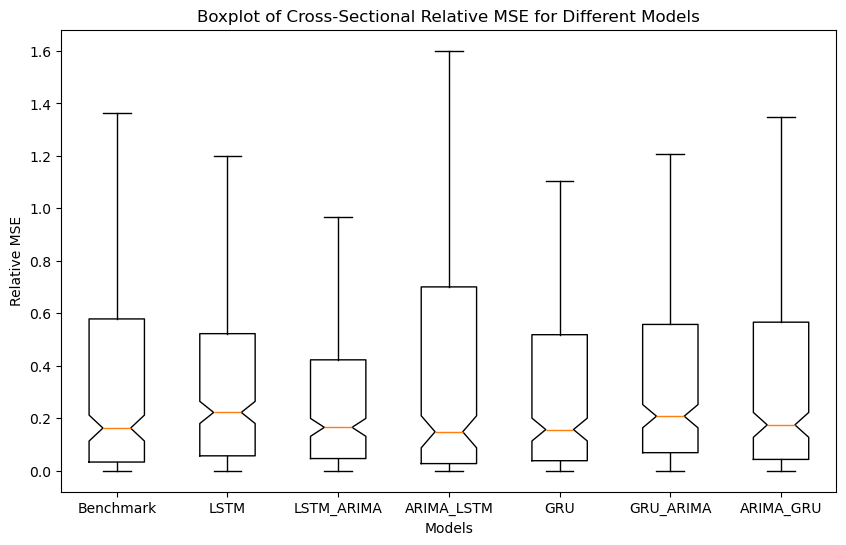

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative MSE for each model
models = df_vol.columns[:-1]  # Extract the model names from df_vol
relative_mse_values = []

for model in models:
    mse_values = (df_vol['Test_data'] - df_vol[model]) ** 2
    relative_mse = mse_values / np.mean(mse_values)
    relative_mse_values.append(relative_mse)

# Create boxplots of relative MSE for different models
plt.figure(figsize=(10, 6))
plt.boxplot(relative_mse_values, vert=True, showfliers=False, notch=True, labels=models)
plt.xlabel('Models')
plt.ylabel('Relative MSE')
plt.title('Boxplot of Cross-Sectional Relative MSE for Different Models')
plt.show()
